# Homework 2 Parts 1-3: Word2Vec

This homework will have you implementing word2vec using PyTorch and let you familiarize yourself with building more complex neural networks and the larger PyTorch development infrastructure.

Broadly, this homework consists of a few major parts:
1. Implement a `Corpus` class that will load the dataset and convert it to a sequence of token ids
2. Implement negative sampling to select tokens to be used as negative examples of words in the context
3. Create your dataset of positive and negative examples per context and load it into PyTorch's `DataLoader` to use for sampling
4. Implement a `Word2Vec` class that is a PyTorch neural network
5. Implement a training loop that samples a _batch_ of target words and their respective positive/negative context words
6. Implement rare word removal and frequent word subsampling
7. Run your model on the full dataset for at least one epoch
8. Do the exploratory parts of the homework
9. Save vectors and word-indexing data for later use in training a classifier

After Step 5, you should be able to run your word2vec implementation on a small dataset and verify that it's learning correctly. Once you can verify everything is working, proceed with steps 6 and beyond. **Please note that this list is a general sketch and the homework PDF has the full list/description of to-dos and all your deliverables.**

### Estimated performance times on medium dataset

We designed this homework to be run on a laptop-grade CPU, so no GPU is required. If your primary computing device is a tablet or similar device, this homework can also be _developed_ on that device but then run on a more powerful machine in the Great Lakes cluster (for free). Such cases are the exception though. Following, we report on the estimated times from our reference implementation on the medium dataset for longer-running or data-intensive pieces of the homework. Your timing may vary based on implementation design; major differences in time (e.g., 10x longer) usually point to a performance bug.

* Reading and tokenizing: ~5 seconds
* Subsampling and converting to token ids: ~15 seconds
* Generating the list of training examples: ~2 minutes (~15 minutes before the random number generator fix)
* Training one epoch: ~12 minutes

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from tqdm.auto import tqdm, trange
from collections import Counter
import random
from torch import optim
import gzip
import time
import wandb
import json
import matplotlib.pyplot as plt
import math
# Helpful for computing cosine similarity--Note that this is NOT a similarity!
from scipy.spatial.distance import cosine

# Handy command-line argument parsing
import argparse
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Sort of smart tokenization
from nltk.tokenize import RegexpTokenizer

# We'll use this to save our models
from gensim.models import KeyedVectors
from torch.utils.tensorboard import SummaryWriter
import os
import pickle

#
# IMPORTANT NOTE: Always set your random seeds when dealing with stochastic
# algorithms as it lets your bugs be reproducible and (more importantly) it lets
# your results be reproducible by others.
#
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16979\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Create an efficient random number generator (do this part this later)

Computers have to work to generate random numbers. However, the effort for getting those random numbers varies by how many you ask for. In practice, it's _much_ more efficient to generate many random numbers at once, rather than one at a time. 


In generating the training data for word2vec, you'll be generating a lot of random numbers. We've added a helpful class that you can use to eventually speed things up. You should use an instance of this `RandomNumberGenerator` class to generate the numbers you need (rather than using `np.random`). This class should work as a quick drop-in in its current implementation. **You should change the implementation of this class _only_ after getting the rest of your code debugged**. Once you get things working, update the code in this class so that it will create large buffers of random numbers and then when asked for a new number, read the next number from the buffer instead of calling `random` or `randint`. Essentially, this class will pre-allocate many random numbers ahead of time and then return them in order to avoid the overhead of generating them one at a time. You could see up to an ~80% performance improvement in your negatve sampling code generation as a result of this!

In [2]:
class RandomNumberGenerator:
    ''' 
    A wrapper class for a random number generator that will (eventually) hold buffers of pre-generated random numbers for
    faster access. For now, it just calls np.random.randint and np.random.random to generate these numbers 
    at the time they are needed.
    '''

    def __init__(self, buffer_size, seed=12345):
        '''
        Initializes the random number generator with a seed and a buffer size of random numbers to use

        Args:
            buffer_size: The number of random numbers to pre-generate. You will eventually want 
                         this to be a large-enough number than you're not frequently regenerating the buffer
            seed: The seed for the random number generator
        '''
        # TODO (later): create a random number generator using numpy and set its seed    
        # TODO (later): pre-generate a buffer of random floats to use for random()
        self.buffer_size = buffer_size
        self.seed = seed
        self.rng = np.random.default_rng(seed)  # Create a random number generator with the seed
        self.float_buffer = self.rng.random(buffer_size)  # Pre-generate a buffer of random floats
        self.int_buffer = None
        self.max_val = -1
        self.float_buffer_index = 0  # Keep track of the current position in the float buffer
        self.int_buffer_index = 0  # Keep track of the current position in the int buffer


    def random(self):
        '''
        Returns a random float value between 0 and 1
        '''
        # TODO (later): get a random number from the float buffer, rather than calling np.random.random
        # NOTE: If you reach the end of the buffer, you should refill it with new random float numbers
        if self.float_buffer_index >= self.buffer_size:
            # Refill the float buffer if we've used all the values
            self.float_buffer = self.rng.random(self.buffer_size)
            self.float_buffer_index = 0
        value = self.float_buffer[self.float_buffer_index]
        self.float_buffer_index += 1
        return value

    def set_max_val(self, max_val):
        '''
        Sets the maximum integer value for randint and creates a buffer of random integers
        '''
        # NOTE: This default implemenation just sets the max_val and does not create a buffer of random integers
        # TODO (later): Implement a buffer of random integers (for now, we'll just use np.random.randint)
        self.max_val = max_val
        self.int_buffer = self.rng.integers(0, max_val + 1, self.buffer_size)
        self.int_buffer_index = 0

    def randint(self):
        '''
        Returns a random int value between 0 and self.max_val (inclusive)
        '''        
        # TODO (later): get a random number from the int buffer, rather than calling np.random.randint
        # NOTE: If you reach the end of the buffer, you should refill it with new random ints
        if self.max_val == -1:
            raise ValueError("Need to call set_max_val before calling randint")
        
        if self.int_buffer_index >= self.buffer_size:
            # Refill the int buffer if we've used all the values
            self.int_buffer = self.rng.integers(0, self.max_val + 1, self.buffer_size)
            self.int_buffer_index = 0
        value = self.int_buffer[self.int_buffer_index]
        self.int_buffer_index += 1
        return value

## Create a class to hold the data

Before we get to training word2vec, we'll need to process the corpus into some representation. The `Corpus` class will handle much of the functionality for corpus reading and keeping track of which word types belong to which ids. The `Corpus` class will also handle the crucial functionality of generating negative samples for training (i.e., randomly-sampled words that were not in the target word's context).

Some parts of this class can be completed after you've gotten word2vec up and running, so see the notes below and the details in the homework PDF.

In [3]:
class Corpus:
    
    def __init__(self, rng: RandomNumberGenerator):

        self.tokenizer = RegexpTokenizer(r'\w+')
        self.rng = rng

        # These state variables become populated with function calls
        #
        # 1. load_data()
        # 2. generate_negative_sampling_table()
        #
        # See those functions for how the various values get filled in

        self.word_to_index = {} # word to unique-id
        self.index_to_word = {} # unique-id to word

        # How many times each word occurs in our data after filtering
        self.word_counts = Counter()

        # A utility data structure that lets us quickly sample "negative"
        # instances in a context. This table contains unique-ids
        self.negative_sampling_table = []
        
        # The dataset we'll use for training, as a sequence of unqiue word
        # ids. This is the sequence across all documents after tokens have been
        # randomly subsampled by the word2vec preprocessing step
        self.full_token_sequence_as_ids = None
        
        self.word_probability = {}
        
    def tokenize(self, text):
        '''
        Tokenize the document and returns a list of the tokens
        '''
        return self.tokenizer.tokenize(text)        

    def load_data(self, file_name, min_token_freq):
        '''
        Reads the data from the specified file as long long sequence of text
        (ignoring line breaks) and populates the data structures of this
        word2vec object.
        '''

        # Step 1: Read in the file and create a long sequence of tokens for
        # all tokens in the file
        all_tokens = []
        print('Reading data and tokenizing')
        with gzip.open(file_name, "rt", encoding="utf-8") as file:
            all_tokens = self.tokenize(file.read().lower())
        # with open(file_name, "r", encoding="utf-8") as file:
        #     all_tokens = self.tokenize(file.read().lower())
    
        # Step 2: Count how many tokens we have of each type
        print('Counting token frequencies')
        for token in all_tokens:
            self.word_counts[token] += 1
        
        # Step 3: Replace all tokens below the specified frequency with an <UNK>
        # token. 
        #
        # NOTE: You can do this step later if needed
        print("Performing minimum thresholding")
        all_tokens = ['<UNK>' if self.word_counts[token] < min_token_freq else token for token in all_tokens]

        # Step 4: update self.word_counts to be the number of times each word
        # occurs (including <UNK>)
        print('Updating token frequencies after filtering <UNK>')
        self.word_counts = Counter(all_tokens)
        
        # Step 5: Create the mappings from word to unique integer ID and the
        # reverse mapping.
        print("Create words and id mapping")
        self.word_to_index = {word: i for i, word in enumerate(self.word_counts.keys())}
        self.index_to_word = {i: word for word, i in self.word_to_index.items()}
        
        # Step 6: Compute the probability of keeping any particular *token* of a
        # word in the training sequence, which we'll use to subsample. This subsampling
        # avoids having the training data be filled with many overly common words
        # as positive examples in the context
        print("Compute probability of subsampling")
        total_word_counts = sum(self.word_counts.values())
        for word, count in self.word_counts.items():
            freq = count / total_word_counts
            self.word_probability[word] = (np.sqrt(freq / 0.001) + 1) * (0.001 / freq)
                        
        # Step 7: process the list of tokens (after min-freq filtering) to fill
        # a new list self.full_token_sequence_as_ids where 
        #
        # (1) we probabilistically choose whether to keep each *token* based on the
        # subsampling probabilities (note that this does not mean we drop
        # an entire word!) and 
        #
        # (2) all tokens are convered to their unique ids for faster training.
        #
        # NOTE: You can skip the subsampling part and just do step 2 to get
        # your model up and running.
            
        # NOTE 2: You will perform token-based subsampling based on the probabilities in
        # word_to_sample_prob. When subsampling, you are modifying the sequence itself 
        # (like deleting an item in a list). This action effectively makes the context
        # window  larger for some target words by removing context words that are common
        # from a particular context before the training occurs (which then would now include
        # other words that were previously just outside the window).
        print("Create all token ID list")
        token_sequence_as_ids = []
        for token in all_tokens:
            if random.random() < self.word_probability.get(token, 1):  # Ensure default probability is 1 for missing tokens
                token_sequence_as_ids.append(self.word_to_index[token])
        
        self.full_token_sequence_as_ids = np.array(token_sequence_as_ids, dtype=np.int32)

        print('Loaded all data from %s; saw %d tokens (%d unique)' % (file_name, len(self.full_token_sequence_as_ids), len(self.word_to_index)))
        
    def generate_negative_sampling_table(self, exp_power=0.75, table_size=1e6):
        '''
        Generates a big list data structure that we can quickly randomly index into
        in order to select a negative training example (i.e., a word that was
        *not* present in the context). 
        '''       
        
        # Step 1: Figure out how many instances of each word need to go into the
        # negative sampling table. 
        #
        # HINT: np.power and np.fill might be useful here        
        print("Generating negative sampling table")
        word_weights = np.array([count**exp_power for count in self.word_counts.values()])
        total_weight = sum(word_weights)

        # Step 2: Create the table to the correct size. You'll want this to be a
        # numpy array of type int
        sampling_probabilities = word_weights / total_weight

        # Step 3: Fill the table so that each word has a number of IDs
        # proportionate to its probability of being sampled.
        #
        # Example: if we have 3 words "a" "b" and "c" with probabilites 0.5,
        # 0.33, 0.16 and a table size of 6 then our table would look like this
        # (before converting the words to IDs):
        #
        # [ "a", "a", "a", "b", "b", "c" ]
        table_size = int(table_size)
        self.negative_sampling_table = np.random.choice(list(self.word_to_index.values()), size=table_size, p=sampling_probabilities)

        # 此时，设置 RandomNumberGenerator 的最大值
        max_val = len(self.negative_sampling_table) - 1  # 因为索引是从0开始的
        self.rng.set_max_val(max_val)
        
    def generate_negative_samples(self, cur_context_word_id, num_samples):
        '''
        Randomly samples the specified number of negative samples from the lookup
        table and returns this list of IDs as a numpy array. As a performance
        improvement, avoid sampling a negative example that has the same ID as
        the current positive context word.
        '''

        # Create a list and sample from the negative_sampling_table to
        # grow the list to num_samples, avoiding adding a negative example that
        # has the same ID as the current context_word
        samples = []
        while len(samples) < num_samples:
            sampled_id = self.rng.randint() % len(self.negative_sampling_table)
            if self.negative_sampling_table[sampled_id] != cur_context_word_id:
                samples.append(self.negative_sampling_table[sampled_id])
        return np.array(samples[:num_samples])

## Create the corpus

Now that we have code to turn the text into training data, let's do so. We've provided several files for you to help:

* `reviews-word2vec.tiny.txt` -- use this to debug your corpus reader
* `reviews-word2vec.med.txt` -- use this to debug/verify the whole word2vec works
* `reviews-word2vec.large.txt.gz` -- use this when everything works to generate your vectors for later parts
* `reviews-word2vec.HUGE.gz` -- _do not use this_ unless (1) everything works and (2) you really want to test/explore. This file is not needed at all to do your homework.

We recommend starting to debug with the first file, as it is small and fast to load (quicker to find bugs). When debugging, we recommend setting the `min_token_freq` argument to 2 so that you can verify that part of the code is working but you still have enough word types left to test the rest.

You'll use the remaining files later, where they're described.

In the next cell, create your `Corpus`, read in the data, and generate the negative sampling table.

In [4]:
corpus = Corpus(rng=RandomNumberGenerator(12345))
corpus.load_data('reviews-word2vec.large.txt.gz', 10)  # 使用新的.gz数据集文件名
# corpus.load_data('reviews-word2vec.large.txt.gz', 5)
corpus.generate_negative_sampling_table()

Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Updating token frequencies after filtering <UNK>
Create words and id mapping
Compute probability of subsampling
Create all token ID list
Loaded all data from reviews-word2vec.large.txt.gz; saw 15087619 tokens (28034 unique)
Generating negative sampling table


## Generate the training data

Once we have the corpus ready, we need to generate our training dataset. Each instance in the dataset is a target word and positive and negative examples of contexts words. Given the target word as input, we'll want to predict (or not predict) these positive and negative context words as outputs using our network. Your task here is to create a python `list` of instances. 

Your final training data should be a list of tuples in the format ([target_word_id], [word_id_1, ...], [predicted_labels]), where each item in the list is a list:
1. The first item is a list consisting only of the target word's ID.
2. The second item is a list of word ids for both context words and negative samples 
3. The third item is a list of labels to predicted for each of the word ids in the second list (i.e., `1` for context words and `0` for negative samples). 

You will feed these tuples into the PyTorch `DatasetLoader` later that will do the converstion to `Tensor` objects. You will need to make sure that all of the lists in each tuple are `np.array` instances and are not plain python lists for this `Tensor` converstion to work.

In [5]:
def generate_training_data(corpus, window_size=2, num_negative_samples_per_target=2):
    sequence_length = len(corpus.full_token_sequence_as_ids)
    training_data = []
    
    for i in tqdm(range(sequence_length)):
        target_id = corpus.full_token_sequence_as_ids[i]
        
        # 初始化上下文窗口，然后移除目标词
        context_window = np.arange(max(0, i - window_size), min(sequence_length, i + window_size + 1))
        valid_context_ids = []
        
        for idx in context_window:
            if idx != i:  # 排除目标词本身
                word = corpus.index_to_word[corpus.full_token_sequence_as_ids[idx]]
                # 检查word既不是停用词、也不是"<UNK>"、也不全是数字
                if word not in stop_words and word != "<UNK>" and not word.isdigit():
                    valid_context_ids.append(idx)

        
        num_positive_samples = len(valid_context_ids)

        max_context_words = (2 * window_size) * (1 + num_negative_samples_per_target)
        context_ids = np.zeros(max_context_words, dtype=int)
        context_labels = np.zeros(max_context_words, dtype=float)

        # 设置正样本和标签
        context_ids[:num_positive_samples] = corpus.full_token_sequence_as_ids[valid_context_ids]
        context_labels[:num_positive_samples] = 1.0

        # 生成负样本
        total_samples_needed = max_context_words - num_positive_samples
        negative_samples = corpus.generate_negative_samples(target_id, total_samples_needed)

        # 设置负样本和标签
        context_ids[num_positive_samples:num_positive_samples + total_samples_needed] = negative_samples
        context_labels[num_positive_samples:num_positive_samples + total_samples_needed] = 0.0

        training_data.append((target_id, context_ids, context_labels))
    
    return training_data
    
training_data = generate_training_data(corpus, window_size=2, num_negative_samples_per_target=2)

    # For each target word in our dataset, select context words 
    # within +/- the window size in the token sequence
    
    # For each positive target, we need to select negative examples of
    # words that were not in the context. Use the num_negative_samples_per_target
    # hyperparameter to generate these, using the generate_negative_samples()
    # method from the Corpus class

    # NOTE: this part might not make sense until later when you do the training 
    # so feel free to revisit it to see why it happens.
    #
    # Our training will use batches of instances together (compare that 
    # with HW1's SGD that used one item at a time). PyTorch will require
    # that all instances in a batches have the same size, which creates an issue
    # for us here since the target words at the very beginning or end of the corpus
    # have shorter contexts. 
    # 
    # To work around these edge-cases, we need to ensure that each instance has
    # the same size, which means it needs to have the same number of positive
    # and negative examples. Since we are short on positive examples here (due
    # to the edge of the corpus), we can just add more negative samples.
    #
    # YOUR TASK: determine what is the maximum number of context words (positive
    # and negative) for any instance and then, for instances that have fewer than
    # this number of context words, add in negative examples.
    #
    # NOTE: The maximum is fixed, so you can precompute this outside the loop
    # ahead of time.

  0%|          | 0/15087619 [00:00<?, ?it/s]

## Create the network

We'll create a new neural network as a subclass of `nn.Module` like we did in Homework 1. However, _unlike_ the network you built in Homework 1, we do not need to used linear layers to implement word2vec. Instead, we will use PyTorch's `Emedding` class, which maps an index (e.g., a word id in this case) to an embedding. 

Roughly speaking, word2vec's network makes a prediction by computing the dot product of the target word's embedding and a context word's embedding and then passing this dot product through the sigmoid function ($\sigma$) to predict the probability that the context word was actually in the context. The homework write-up has lots of details on how this works. Your `forward()` function will have to implement this computation.

In [6]:
class Word2Vec(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        
        # Save what state you want and create the embeddings for your
        # target and context words
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size # feature
        self.target_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.sig = nn.Sigmoid()
        
        # Once created, let's fill the embeddings with non-zero random
        # numbers. We need to do this to get the training started. 
        #
        # NOTE: Why do this? Think about what happens if all the embeddings
        # are all zeros initially. What would the predictions look like for
        # word2vec with these embeddings and how would the updated work?
        
        self.init_emb(init_range=0.5/self.vocab_size)
        
    def init_emb(self, init_range):
        
        # Fill your two embeddings with random numbers uniformly sampled
        # between +/- init_range
        self.target_embeddings.weight.data.uniform_(-init_range, init_range)
        self.context_embeddings.weight.data.uniform_(-init_range, init_range)
        
    def forward(self, target_word_id, context_word_ids):
        ''' 
        Predicts whether each context word was actually in the context of the target word.
        The input is a tensor with a single target word's id and a tensor containing each
        of the context words' ids (this includes both positive and negative examples).
        '''
        
        # NOTE 1: This is probably the hardest part of the homework, so you'll
        # need to figure out how to do the dot-product between embeddings and return
        # the sigmoid. Be prepared for lots of debugging. For some reference,
        # our implementation is three lines and really the hard part is just
        # the last line. However, it's usually a matter of figuring out what
        # that one line looks like that ends up being the hard part.
        
        # NOTE 2: In this homework you'll be dealing with *batches* of instances
        # rather than a single instance at once. PyTorch mostly handles this
        # seamlessly under the hood for you (which is very nice) but batching
        # can show in weird ways and create challenges in debugging initially.
        # For one, your inputs will get an extra dimension. So, for example,
        # if you have a batch size of 4, your input for target_word_id will
        # really be 4 x 1. If you get the embeddings of those targets,
        # it then becomes 4x50! The same applies to the context_word_ids, except
        # that was alreayd a list so now you have things with shape 
        #
        #    (batch x context_words x embedding_size)
        #
        # One of your tasks will be to figure out how to get things lined up
        # so everything "just works". When it does, the code looks surprisingly
        # simple, but it might take a lot of debugging (or not!) to get there.
        
        # NOTE 3: We *strongly* discourage you from looking for existing 
        # implementations of word2vec online. Sadly, having reviewed most of the
        # highly-visible ones, they are actually wrong (wow!) or are doing
        # inefficient things like computing the full softmax instead of doing
        # the negative sampling. Looking at these will likely leave you more
        # confused than if you just tried to figure it out yourself.
        
        # NOTE 4: There many ways to implement this, some more efficient
        # than others. You will want to get it working first and then
        # test the timing to see how long it takes. As long as the
        # code works (vector comparisons look good) you'll receive full
        # credit. However, very slow implementations may take hours(!)
        # to converge so plan ahead.
        
        
        # Hint 1: You may want to review the mathematical operations on how
        # to compute the dot product to see how to do these
        
        # Hint 2: the "dim" argument for some operations may come in handy,
        # depending on your implementation
        
           
        # TODO: Implement the forward pass of word2vec
        target_embedding = self.target_embeddings(target_word_id)
        context_embeddings = self.context_embeddings(context_word_ids)
        
        # 计算点积并应用Sigmoid函数
        # 需要调整形状以支持批处理和多个上下文词
        scores = torch.bmm(context_embeddings, target_embedding.unsqueeze(2)).squeeze(2)
        predictions = self.sig(scores)
        
        return predictions

## Train the network!

Now that you have data in the right format and a neural network designed, it's time to train the network and see if it's all working. The trainin code will look surprisingly similar at times to your pytorch code from Homework 1 since all networks share the same base training setup. However, we'll add a few new elements to get you familiar with more common training techniques. 

For all steps, be sure to use the hyperparameters values described in the write-up.

1. Initialize your optimizer and loss function 
2. Create your network
3. Load your dataset into PyTorch's `DataLoader` class, which will take care of batching and shuffling for us (yay!)
4. Create a new `SummaryWriter` to periodically write our running-sum of the loss to a tensorboard
5. Train your model 

Two new elements show up. First, we'll be using `DataLoader` which is going to sample data for us and put it in a batch (and also convert the data to `Tensor` objects. You can iterate over the batches and each iteration will return all the items eventually, one batch at a time (a full epoch's worth).

The second new part is using `wandb`. As you might have noticed in Homework 1, training neural models can take some time. [Weights & Biases](https://wandb.ai/) is a handy web-based view that you can check during training to see how the model is doing. We'll use it here and periodically log a running sum of the loss after a set number of steps. The Homework write up has a plot of what this looks like. We'll be doing something simple here with wandb but it will come in handy later as you train larger models (for longer) and may want to visually check if your model is converging and is [easy to integrate](https://docs.wandb.ai/guides/integrations/pytorch).

Once you get the code working, to start training, we recommend training on the `reviews-word2vec.med.txt` dataset. This data is small enough you can get through an epoch in a few minutes (or less) while still being large enough you can test whether the model is learning anything by examining common words. Below this cell we've added a few helper functions that you can use to debug and query your model. In particular, the `get_neighbors()` function is a great way to test: if your model has learned anything, the nearest neighbors for common words should seem reasonable (without having to jump through mental hoops). An easy word to test on the `med` data is "january" which should return month-related words as being most similar.

**NOTE**: Since we're training biographies, the text itself will be skewed towards words likely to show up biographices--which isn't necessary like "regular" text. You may find that your model has few instances of words you think are common, or that the model learns poor or unusual neighbors for these. When querying the neighbors, it can help to think of which words you think are likely to show up in biographies on Wikipedia and use those as probes to see what the model has learned.

Once you're convinced the model is learning, switch to the `med` data and train your model as specified in the PDF. Once trained, save your model using the `save()` function at the end of the notebook. This function records your data in a common format for word2vec vectors and lets you load the vectors into other libraries that have more advanced functionality. In particular, you can use the [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) code in other notebook included to explore the vectors and do simple vector analogies.

In [7]:
# TODO: Set your training stuff, hyperparameters, models, etc. here
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vocab_size = len(corpus.word_counts)
embedding_size = 50
window_size = 2
num_negative_samples_per_target = 2
context_size = (2 * window_size) * (1 + num_negative_samples_per_target) # 12
lr = 0.001
max_step = 1000000000

  0%|          | 0/7543810 [00:00<?, ?it/s]

  0%|          | 0/1885953 [00:00<?, ?it/s]

  0%|          | 0/471489 [00:00<?, ?it/s]

  0%|          | 0/235745 [00:00<?, ?it/s]

  0%|          | 0/117873 [00:00<?, ?it/s]

  0%|          | 0/58937 [00:00<?, ?it/s]

  0%|          | 0/29469 [00:00<?, ?it/s]

  0%|          | 0/14735 [00:00<?, ?it/s]

  0%|          | 0/7368 [00:00<?, ?it/s]

  0%|          | 0/3684 [00:00<?, ?it/s]

  0%|          | 0/1842 [00:00<?, ?it/s]

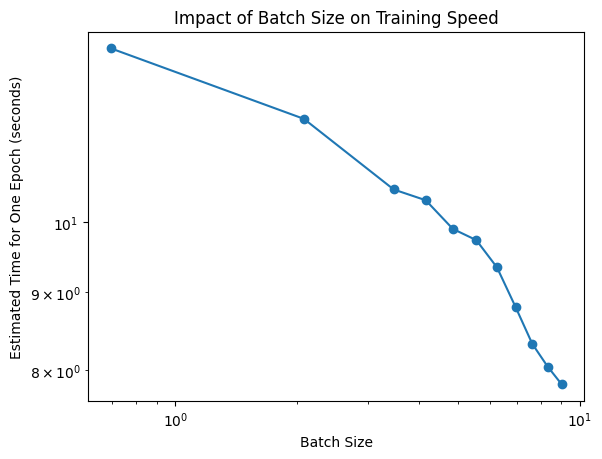

In [8]:
model = Word2Vec(vocab_size, embedding_size)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr = lr)

batch_sizes = [2, 8, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
times_per_batch = []
estimated_times_per_epoch = []

last_loss_sum = 0
loss_sum = 0
for batch_size in batch_sizes:
    model = model.to(device)
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    writer = SummaryWriter()

    start_time = time.time()
    for step, data in enumerate(tqdm(train_dataloader)):
        if step >= 300:  # 仅运行前100个批次来估计速度
            break

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data

        # for GPU training
        target_ids = target_ids.to(device)
        context_ids = context_ids.to(device)
        labels = labels.to(device)

        # TODO: Fill in all the training details here
        optimizer.zero_grad()
        outputs = torch.reshape(model(target_ids, context_ids), (-1, context_size))
        loss = criterion(outputs.float(), labels.float())
        loss_sum += loss.item()  # Adjusted to add item() for correct summation
        loss.backward()
        optimizer.step()

    end_time = time.time()

    time_per_batch = (end_time - start_time) / 100
    times_per_batch.append(time_per_batch)
    estimated_time_per_epoch = time_per_batch * len(train_dataloader)
    estimated_times_per_epoch.append(estimated_time_per_epoch)

batch = []
times = []
for batch1 in batch_sizes:
    batch.append(math.log(batch1))
    
for time1 in estimated_times_per_epoch:
    times.append(math.log(time1))
    
# 绘制结果
plt.plot(batch, times, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Batch Size')
plt.ylabel('Estimated Time for One Epoch (seconds)')
plt.title('Impact of Batch Size on Training Speed')
plt.show()

In [9]:
best_batch_size = 2048
num_epoch = 15
train_dataloader = DataLoader(training_data, batch_size=best_batch_size, shuffle=True)

# init the model
model = Word2Vec(vocab_size, embedding_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.BCELoss()
writer = SummaryWriter()

# TODO: Initialize weights and biases (wandb) here 
wandb.init(project="word2vec_project", entity="yanzhuo")
wandb.config = {
    "learning_rate": lr,
    "epochs": num_epoch,
    "batch_size": best_batch_size,
}

# 可选：记录模型结构
wandb.watch(model, log="all")

# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take
for epoch in range(num_epoch):
    print("Epoch ", epoch)
    loss_sum = 0
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(train_dataloader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = [d.to(device) for d in data]
        
        # TODO: Fill in all the training details here
        optimizer.zero_grad()
        outputs = model(target_ids, context_ids).squeeze()
        loss = criterion(outputs, labels.float())
        loss_sum += loss.item()  # Adjusted to add item() for correct summation
        loss.backward()
        optimizer.step()
        
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        if (step + 1) % 3000 == 0:
            avg_loss = loss_sum / 3000
            print(f"Step {step+1}, Avg Loss: {avg_loss}")
            writer.add_scalar('Loss/train', avg_loss, epoch * len(train_dataloader) + step)
            wandb.log({"Cumulative Loss": avg_loss})
            loss_sum = 0  # 重置损失和
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        if step > max_step:
            print("Early stopping triggered.")
            break

# once you finish training, it's good practice to switch to eval.
model.eval()
wandb.finish()

wandb: Currently logged in as: yanzhuo. Use `wandb login --relogin` to force relogin


Epoch  0


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.44510532226165134
Step 6000, Avg Loss: 0.40595842750867206
Epoch  1


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.390616644769907
Step 6000, Avg Loss: 0.38703961595892905
Epoch  2


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.38158667236566546
Step 6000, Avg Loss: 0.381240032295386
Epoch  3


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.3779819760521253
Step 6000, Avg Loss: 0.3785467916627725
Epoch  4


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.3760322779715061
Step 6000, Avg Loss: 0.3770103766421477
Epoch  5


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.3747740228076776
Step 6000, Avg Loss: 0.37599988949298857
Epoch  6


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.3739227110842864
Step 6000, Avg Loss: 0.37525546486179034
Epoch  7


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.37333061899741493
Step 6000, Avg Loss: 0.37463592676321666
Epoch  8


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.3727861280341943
Step 6000, Avg Loss: 0.3741743798851967
Epoch  9


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.3723661517004172
Step 6000, Avg Loss: 0.37387230136990546
Epoch  10


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.3721645218729973
Step 6000, Avg Loss: 0.3735047985215982
Epoch  11


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.37184598062435786
Step 6000, Avg Loss: 0.3733069178164005
Epoch  12


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.37159786451856297
Step 6000, Avg Loss: 0.3731134965717792
Epoch  13


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.37141147152582804
Step 6000, Avg Loss: 0.3729581948121389
Epoch  14


  0%|          | 0/7368 [00:00<?, ?it/s]

Step 3000, Avg Loss: 0.37120790778597196
Step 6000, Avg Loss: 0.37272299131751063


Cumulative Loss,█▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Cumulative Loss,0.37272


## Verify things are working

Once you have an initial model trained, try using the following code to query the model for what are the nearest neighbor of a word. This code is intended to help you debug

In [10]:
def get_neighbors(model, word_to_index, target_word):
    """ 
    Finds the top 10 most similar words to a target word
    """
    outputs = []
    for word, index in tqdm(word_to_index.items(), total=len(word_to_index)):
        similarity = compute_cosine_similarity(model, word_to_index, target_word, word)
        result = {"word": word, "score": similarity}
        outputs.append(result)

    # Sort by highest scores
    neighbors = sorted(outputs, key=lambda o: o['score'], reverse=True)
    return neighbors[1:11]

def compute_cosine_similarity(model, word_to_index, word_one, word_two):
    '''
    Computes the cosine similarity between the two words
    '''
    try:
        word_one_index = word_to_index[word_one]
        word_two_index = word_to_index[word_two]
    except KeyError:
        return 0

    embedding_one = model.target_embeddings(torch.LongTensor([word_one_index]))
    embedding_two = model.target_embeddings(torch.LongTensor([word_two_index]))
    similarity = 1 - abs(float(cosine(embedding_one.detach().squeeze().numpy(),
                                      embedding_two.detach().squeeze().numpy())))
    return similarity

In [11]:
get_neighbors(model, corpus.word_to_index, "january")

  0%|          | 0/28034 [00:00<?, ?it/s]

[{'word': 'december', 'score': 0.7894909295179718},
 {'word': 'june', 'score': 0.7694162318728313},
 {'word': '25th', 'score': 0.7303972733465446},
 {'word': 'feb', 'score': 0.7249091212620075},
 {'word': 'july', 'score': 0.7135899116338096},
 {'word': 'september', 'score': 0.7117776971546084},
 {'word': 'nov', 'score': 0.7086796582647434},
 {'word': 'november', 'score': 0.7070849717478815},
 {'word': 'aug', 'score': 0.6936001603080195},
 {'word': 'sept', 'score': 0.6928712208184687}]

In [12]:
get_neighbors(model, corpus.word_to_index, "good")

  0%|          | 0/28034 [00:00<?, ?it/s]

[{'word': 'decent', 'score': 0.8822989053483742},
 {'word': 'great', 'score': 0.8543766731405438},
 {'word': 'solid', 'score': 0.7630655019282068},
 {'word': 'okay', 'score': 0.7599079674239136},
 {'word': 'nice', 'score': 0.7498868687328438},
 {'word': 'excellent', 'score': 0.7394255819010411},
 {'word': 'ok', 'score': 0.7340677230243511},
 {'word': 'terrific', 'score': 0.7111313103586898},
 {'word': 'fun', 'score': 0.6802609982706888},
 {'word': 'quick', 'score': 0.6792583044601646}]

# Save your vectors for the gensim inspection part!

Once you have a fully trained model, save it using the code below. Note that we only save the `target_embeddings` from the model, but you could modify the code if you want to save the context vectors--or even try doing fancier things like saving the concatenation of the two or the average of the two!

In [13]:
def save(model, corpus, filename):
    '''
    Saves the model to the specified filename as a gensim KeyedVectors in the
    text format so you can load it separately.
    '''

    # Creates an empty KeyedVectors with our embedding size
    kv = KeyedVectors(vector_size=model.embedding_size)        
    vectors = []
    words = []
    # Get the list of words/vectors in a consistent order
    for index in trange(model.target_embeddings.num_embeddings):
        word = corpus.index_to_word[index]
        vectors.append(model.target_embeddings(torch.LongTensor([index])).detach().numpy()[0])
        words.append(word)

    # Fills the KV object with our data in the right order
    kv.add_vectors(words, vectors) 
    kv.save_word2vec_format(filename, binary=False)

model_name = "min10_model"
save(model.cpu(), corpus, "./models/" + model_name + ".kv")

  0%|          | 0/28034 [00:00<?, ?it/s]

# Save your vectors / data for the pytorch classifier in Part 4!

We'll be to using these vectors later in Part 4. We want to save them in a format that PyTorch can easily use. In particular you'll need to save the _state dict_ of the embeddings, which captures all of its information. 

In [14]:
# 保存模型的嵌入层
torch.save(model.target_embeddings.state_dict(), './models/'+model_name+'_embeddings_state_dict.pt')

# 如果您的模型还包含上下文嵌入层并且您也想保存它：
torch.save(model.context_embeddings.state_dict(), './models/'+model_name+'_context_embeddings_state_dict.pt')

We will also need the mapping from word to index so we can figure out which embedding to use for different words. Save the `corpus` objects mapping to a file using your preferred format (e.g., pickle or json).

In [15]:
# 假设 corpus.word_to_index 是您需要保存的映射
word_to_index = corpus.word_to_index

# 使用pickle保存word_to_index映射
with open('./models/'+model_name+'_word_to_index.pkl', 'wb') as f:
    pickle.dump(word_to_index, f)
    
# 假设 corpus.word_to_index 是您需要保存的映射
index_to_word = corpus.index_to_word

# 使用pickle保存word_to_index映射
with open('./models/'+model_name+'_index_to_word.pkl', 'wb') as f:
    pickle.dump(index_to_word, f)